In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from utils_r2 import FastTensorDataLoader, haversine_distance, TaxiDataModule, RadialBasisNeuralNet, multiquadric, gaussian, MLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
import pytorch_lightning as pl

from torchinfo import summary

pl.seed_everything(42, workers=True)

df = pd.read_csv("NYCTaxiFares.csv", parse_dates=["pickup_datetime"])
df['EDTdate'] = df.pickup_datetime - pd.Timedelta(hours = 4)
df['Hour'] = df.EDTdate.dt.hour
df['AMorPM'] = np.where(df.Hour>=12, 1,0)
df['Weekday'] = df.pickup_datetime.dt.weekday
df["day"] = df.pickup_datetime.dt.day_name()

Global seed set to 42


## EDA

In [3]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                             int64
Weekday                            int64
day                               object
dtype: object

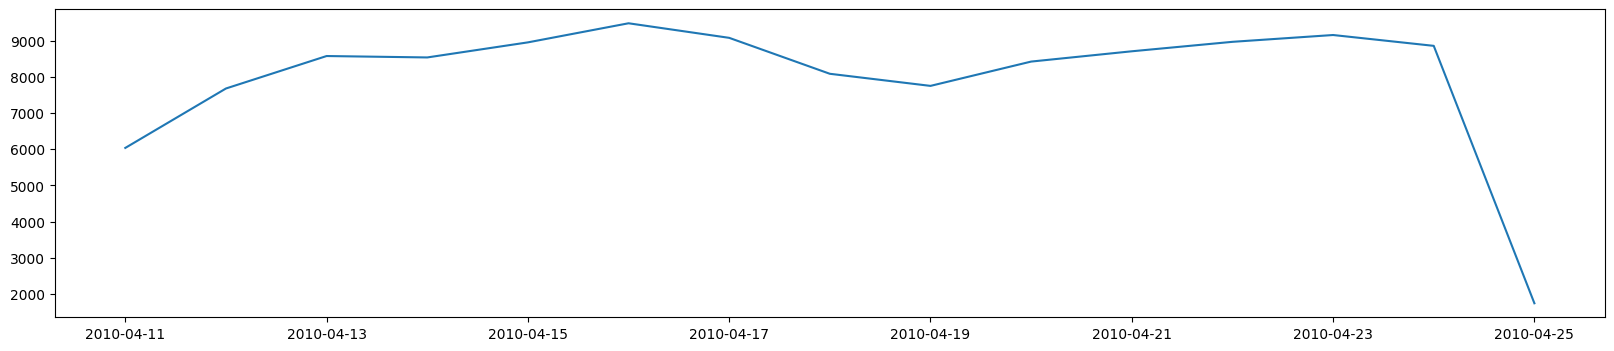

In [4]:
df.pickup_datetime.dt.date.value_counts().plot(figsize=(20,4));

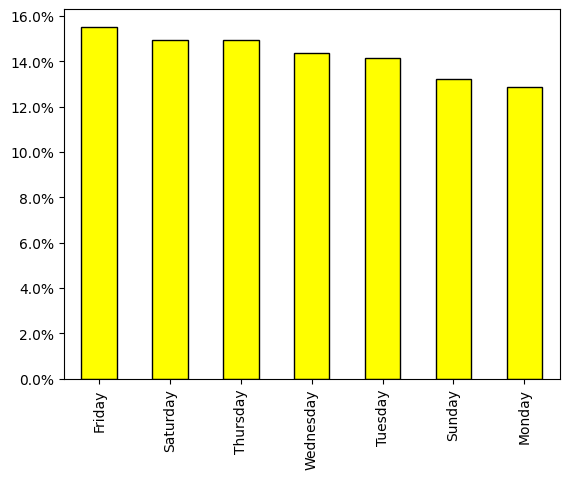

In [5]:
import matplotlib.ticker as mtick
ax = df.pickup_datetime.dt.day_name().value_counts(normalize=True).mul(100).plot(kind = "bar",edgecolor = "black", color = "yellow");
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

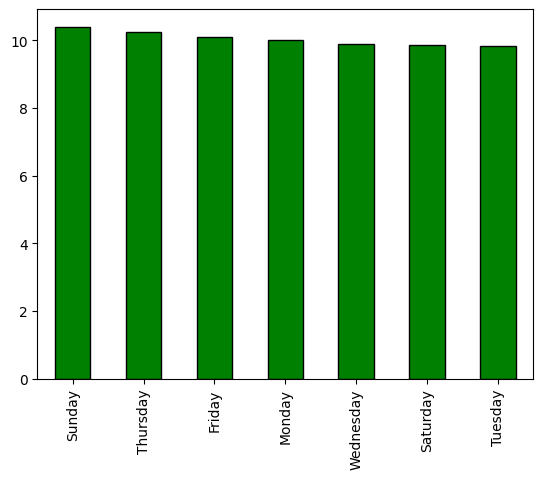

In [6]:
df.groupby("day").fare_amount.mean().sort_values(ascending = False).plot(kind = "bar",edgecolor = "black", color = "green")
plt.xlabel(None);

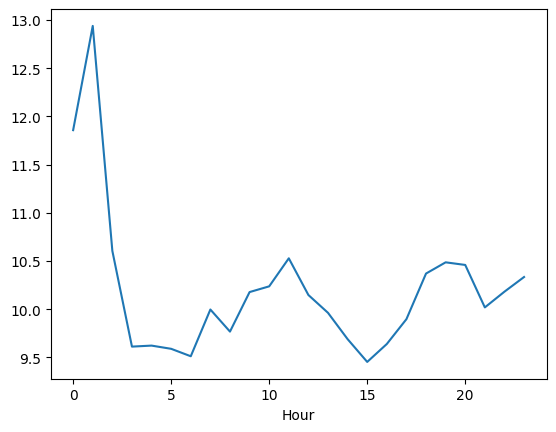

In [7]:
df.groupby("Hour").fare_amount.mean().plot();

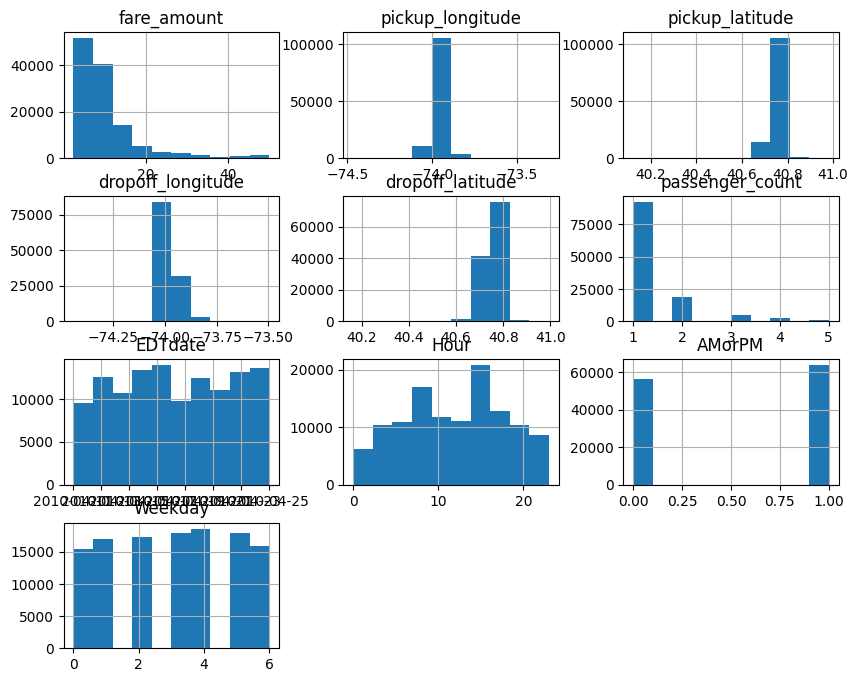

In [8]:
df.drop(columns = ["pickup_datetime","fare_class"]).hist(figsize=(10,8));

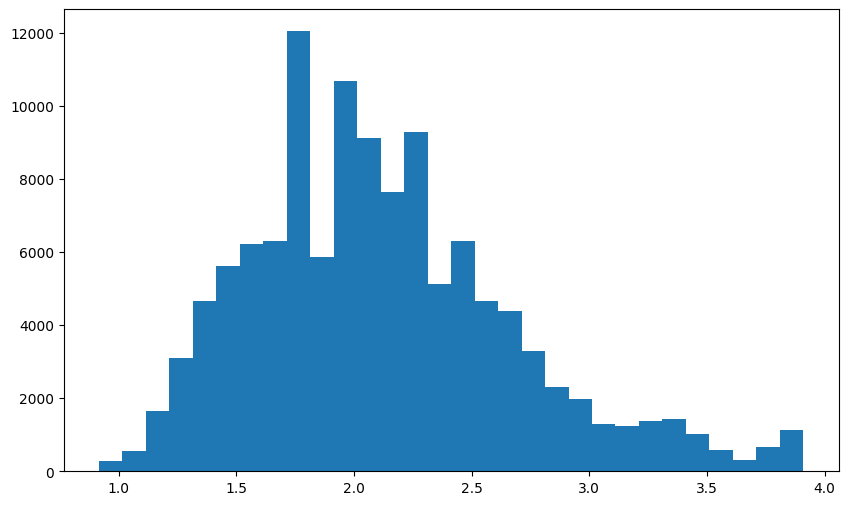

In [12]:
plt.figure(figsize = (10,6))
plt.hist(np.log(df.fare_amount), bins = 30);

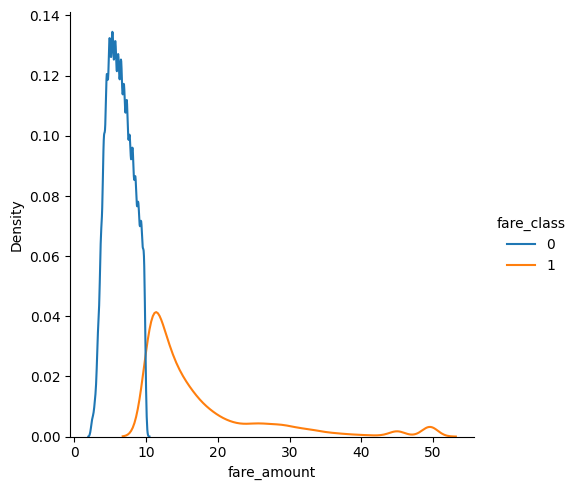

In [9]:
sns.displot(x = "fare_amount", data = df, kind = "kde", hue = "fare_class");

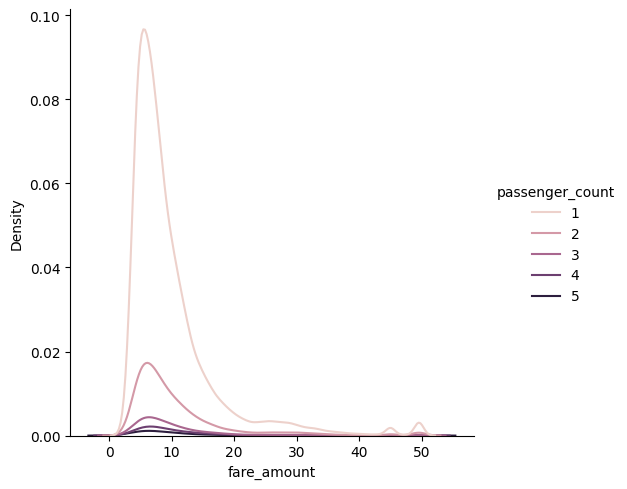

In [10]:
sns.displot(x = "fare_amount", data = df, kind = "kde", hue = "passenger_count");

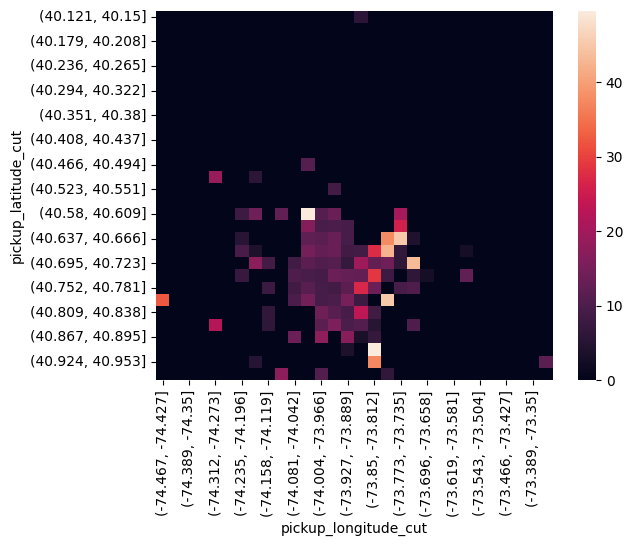

In [11]:
df["pickup_latitude_cut"] = pd.cut(df["pickup_latitude"], 30)
df["pickup_longitude_cut"] = pd.cut(df["pickup_longitude"], 30)

data = df.groupby(["pickup_latitude_cut","pickup_longitude_cut"]).fare_amount.mean().unstack(level = 1, fill_value = 0).fillna(0)
sns.heatmap(data);

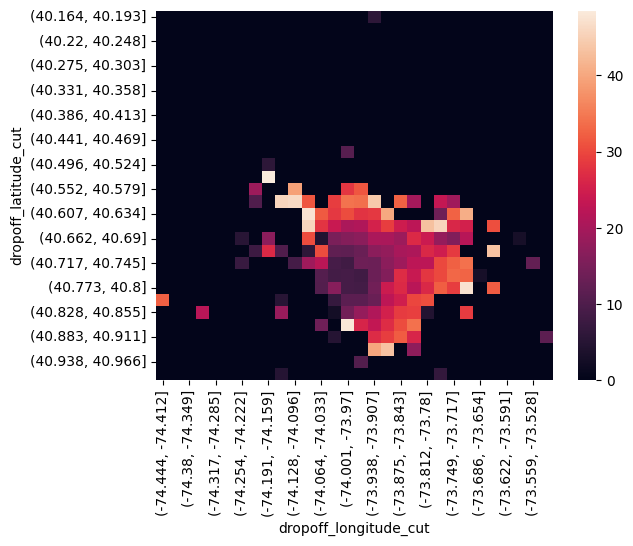

In [12]:
df["dropoff_latitude_cut"] = pd.cut(df["dropoff_latitude"], 30)
df["dropoff_longitude_cut"] = pd.cut(df["dropoff_longitude"], 30)

data = df.groupby(["dropoff_latitude_cut","dropoff_longitude_cut"]).fare_amount.mean().unstack(level = 1, fill_value = 0).fillna(0)
sns.heatmap(data);

## Feature Engineering

In [13]:
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 
                                        'pickup_longitude',
                                        'dropoff_latitude',
                                        'dropoff_longitude')

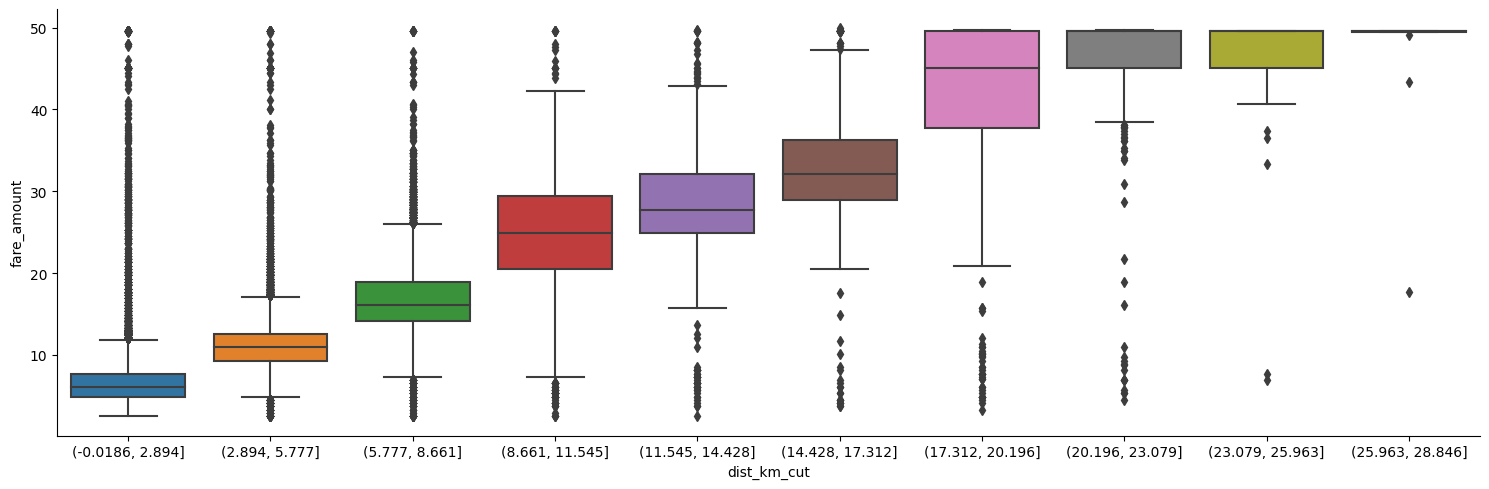

In [14]:
df['dist_km_cut'] = pd.cut(df.dist_km, 10)
sns.catplot(x = "dist_km_cut", y = "fare_amount", data = df, kind = "box", height = 5, aspect = 3);

In [15]:
FEATURES = df.columns[~df.columns.str.contains("_cut")].to_list()
X = df[FEATURES].drop(columns = ["fare_amount","pickup_datetime","EDTdate", "day"])
y = df.fare_amount

In [16]:
LOG = True

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

X_train = torch.from_numpy(X_train).float()

X_val = torch.from_numpy(X_val).float()

if LOG:
    y_train = torch.from_numpy(np.log(y_train.values)).float()
    y_val = torch.from_numpy(np.log(y_val.values)).float()
else:
    y_train = torch.from_numpy(y_train.values).float()
    y_val = torch.from_numpy(y_val.values).float()

X_train.shape, X_val.shape

(torch.Size([84000, 10]), torch.Size([36000, 10]))

# RBF

In [18]:

mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

early_stop = EarlyStopping(monitor = 'val_loss', patience = 15)

dm = TaxiDataModule(X_train, y_train, X_val, y_val, bs=1024)
model = RadialBasisNeuralNet(input_size = 10, hidden_size= 256, output_size= 1, rbf_func = gaussian)
trainer = pl.Trainer(
    max_epochs=500,
    accelerator="gpu",
    devices=1,
    fast_dev_run=False,
    callbacks=[mc, early_stop],
     )
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | rbf       | RBF     | 2.8 K 
1 | fc        | Linear  | 257   
2 | criterion | MSELoss | 0     
--------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 83: 'val_loss' reached 4.16034 (best 4.16034), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=0-step=83.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 166: 'val_loss' reached 2.44263 (best 2.44263), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=1-step=166.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 249: 'val_loss' reached 1.32129 (best 1.32129), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=2-step=249.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 332: 'val_loss' reached 0.97543 (best 0.97543), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=3-step=332.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 415: 'val_loss' reached 0.77491 (best 0.77491), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=4-step=415.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 498: 'val_loss' reached 0.64109 (best 0.64109), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=5-step=498.ckpt' as top 1


A Jupyter Widget

Epoch 6, global step 581: 'val_loss' reached 0.55589 (best 0.55589), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=6-step=581-v1.ckpt' as top 1


A Jupyter Widget

Epoch 7, global step 664: 'val_loss' reached 0.50438 (best 0.50438), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=7-step=664.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 747: 'val_loss' reached 0.46960 (best 0.46960), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=8-step=747.ckpt' as top 1


A Jupyter Widget

Epoch 9, global step 830: 'val_loss' reached 0.44454 (best 0.44454), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=9-step=830.ckpt' as top 1


A Jupyter Widget

Epoch 10, global step 913: 'val_loss' reached 0.42461 (best 0.42461), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=10-step=913.ckpt' as top 1


A Jupyter Widget

Epoch 11, global step 996: 'val_loss' reached 0.40784 (best 0.40784), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=11-step=996.ckpt' as top 1


A Jupyter Widget

Epoch 12, global step 1079: 'val_loss' reached 0.39265 (best 0.39265), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=12-step=1079.ckpt' as top 1


A Jupyter Widget

Epoch 13, global step 1162: 'val_loss' reached 0.37927 (best 0.37927), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=13-step=1162.ckpt' as top 1


A Jupyter Widget

Epoch 14, global step 1245: 'val_loss' reached 0.36796 (best 0.36796), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=14-step=1245.ckpt' as top 1


A Jupyter Widget

Epoch 15, global step 1328: 'val_loss' reached 0.35750 (best 0.35750), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=15-step=1328.ckpt' as top 1


A Jupyter Widget

Epoch 16, global step 1411: 'val_loss' reached 0.34927 (best 0.34927), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=16-step=1411.ckpt' as top 1


A Jupyter Widget

Epoch 17, global step 1494: 'val_loss' reached 0.34231 (best 0.34231), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=17-step=1494.ckpt' as top 1


A Jupyter Widget

Epoch 18, global step 1577: 'val_loss' reached 0.33637 (best 0.33637), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=18-step=1577.ckpt' as top 1


A Jupyter Widget

Epoch 19, global step 1660: 'val_loss' reached 0.33157 (best 0.33157), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=19-step=1660.ckpt' as top 1


A Jupyter Widget

Epoch 20, global step 1743: 'val_loss' reached 0.32767 (best 0.32767), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=20-step=1743.ckpt' as top 1


A Jupyter Widget

Epoch 21, global step 1826: 'val_loss' reached 0.32472 (best 0.32472), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=21-step=1826-v1.ckpt' as top 1


A Jupyter Widget

Epoch 22, global step 1909: 'val_loss' reached 0.32269 (best 0.32269), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=22-step=1909.ckpt' as top 1


A Jupyter Widget

Epoch 23, global step 1992: 'val_loss' reached 0.32077 (best 0.32077), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=23-step=1992.ckpt' as top 1


A Jupyter Widget

Epoch 24, global step 2075: 'val_loss' reached 0.31889 (best 0.31889), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=24-step=2075.ckpt' as top 1


A Jupyter Widget

Epoch 25, global step 2158: 'val_loss' reached 0.31741 (best 0.31741), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=25-step=2158.ckpt' as top 1


A Jupyter Widget

Epoch 26, global step 2241: 'val_loss' reached 0.31625 (best 0.31625), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=26-step=2241.ckpt' as top 1


A Jupyter Widget

Epoch 27, global step 2324: 'val_loss' reached 0.31579 (best 0.31579), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=27-step=2324.ckpt' as top 1


A Jupyter Widget

Epoch 28, global step 2407: 'val_loss' reached 0.31451 (best 0.31451), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=28-step=2407.ckpt' as top 1


A Jupyter Widget

Epoch 29, global step 2490: 'val_loss' reached 0.31382 (best 0.31382), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=29-step=2490-v1.ckpt' as top 1


A Jupyter Widget

Epoch 30, global step 2573: 'val_loss' reached 0.31348 (best 0.31348), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=30-step=2573.ckpt' as top 1


A Jupyter Widget

Epoch 31, global step 2656: 'val_loss' reached 0.31285 (best 0.31285), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=31-step=2656.ckpt' as top 1


A Jupyter Widget

Epoch 32, global step 2739: 'val_loss' reached 0.31243 (best 0.31243), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=32-step=2739.ckpt' as top 1


A Jupyter Widget

Epoch 33, global step 2822: 'val_loss' reached 0.31207 (best 0.31207), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=33-step=2822.ckpt' as top 1


A Jupyter Widget

Epoch 34, global step 2905: 'val_loss' reached 0.31173 (best 0.31173), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=34-step=2905.ckpt' as top 1


A Jupyter Widget

Epoch 35, global step 2988: 'val_loss' reached 0.31147 (best 0.31147), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=35-step=2988-v1.ckpt' as top 1


A Jupyter Widget

Epoch 36, global step 3071: 'val_loss' reached 0.31133 (best 0.31133), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=36-step=3071-v3.ckpt' as top 1


A Jupyter Widget

Epoch 37, global step 3154: 'val_loss' reached 0.31103 (best 0.31103), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=37-step=3154.ckpt' as top 1


A Jupyter Widget

Epoch 38, global step 3237: 'val_loss' reached 0.31086 (best 0.31086), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=38-step=3237.ckpt' as top 1


A Jupyter Widget

Epoch 39, global step 3320: 'val_loss' reached 0.31078 (best 0.31078), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=39-step=3320.ckpt' as top 1


A Jupyter Widget

Epoch 40, global step 3403: 'val_loss' reached 0.31060 (best 0.31060), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=40-step=3403.ckpt' as top 1


A Jupyter Widget

Epoch 41, global step 3486: 'val_loss' reached 0.31043 (best 0.31043), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=41-step=3486.ckpt' as top 1


A Jupyter Widget

Epoch 42, global step 3569: 'val_loss' reached 0.31029 (best 0.31029), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=42-step=3569-v1.ckpt' as top 1


A Jupyter Widget

Epoch 43, global step 3652: 'val_loss' reached 0.31020 (best 0.31020), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=43-step=3652.ckpt' as top 1


A Jupyter Widget

Epoch 44, global step 3735: 'val_loss' reached 0.31011 (best 0.31011), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=44-step=3735.ckpt' as top 1


A Jupyter Widget

Epoch 45, global step 3818: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 46, global step 3901: 'val_loss' reached 0.30994 (best 0.30994), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=46-step=3901.ckpt' as top 1


A Jupyter Widget

Epoch 47, global step 3984: 'val_loss' reached 0.30986 (best 0.30986), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=47-step=3984.ckpt' as top 1


A Jupyter Widget

Epoch 48, global step 4067: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 49, global step 4150: 'val_loss' reached 0.30978 (best 0.30978), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=49-step=4150.ckpt' as top 1


A Jupyter Widget

Epoch 50, global step 4233: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 51, global step 4316: 'val_loss' reached 0.30969 (best 0.30969), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=51-step=4316.ckpt' as top 1


A Jupyter Widget

Epoch 52, global step 4399: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 53, global step 4482: 'val_loss' reached 0.30954 (best 0.30954), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=53-step=4482-v1.ckpt' as top 1


A Jupyter Widget

Epoch 54, global step 4565: 'val_loss' reached 0.30951 (best 0.30951), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=54-step=4565.ckpt' as top 1


A Jupyter Widget

Epoch 55, global step 4648: 'val_loss' reached 0.30943 (best 0.30943), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=55-step=4648.ckpt' as top 1


A Jupyter Widget

Epoch 56, global step 4731: 'val_loss' reached 0.30942 (best 0.30942), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=56-step=4731.ckpt' as top 1


A Jupyter Widget

Epoch 57, global step 4814: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 58, global step 4897: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 59, global step 4980: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 60, global step 5063: 'val_loss' reached 0.30928 (best 0.30928), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=60-step=5063.ckpt' as top 1


A Jupyter Widget

Epoch 61, global step 5146: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 62, global step 5229: 'val_loss' reached 0.30922 (best 0.30922), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=62-step=5229.ckpt' as top 1


A Jupyter Widget

Epoch 63, global step 5312: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 64, global step 5395: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 65, global step 5478: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 66, global step 5561: 'val_loss' reached 0.30915 (best 0.30915), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=66-step=5561.ckpt' as top 1


A Jupyter Widget

Epoch 67, global step 5644: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 68, global step 5727: 'val_loss' reached 0.30911 (best 0.30911), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=68-step=5727-v1.ckpt' as top 1


A Jupyter Widget

Epoch 69, global step 5810: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 70, global step 5893: 'val_loss' reached 0.30910 (best 0.30910), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=70-step=5893.ckpt' as top 1


A Jupyter Widget

Epoch 71, global step 5976: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 72, global step 6059: 'val_loss' reached 0.30903 (best 0.30903), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=72-step=6059-v1.ckpt' as top 1


A Jupyter Widget

Epoch 73, global step 6142: 'val_loss' reached 0.30901 (best 0.30901), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=73-step=6142.ckpt' as top 1


A Jupyter Widget

Epoch 74, global step 6225: 'val_loss' reached 0.30900 (best 0.30900), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=74-step=6225.ckpt' as top 1


A Jupyter Widget

Epoch 75, global step 6308: 'val_loss' reached 0.30899 (best 0.30899), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=75-step=6308-v1.ckpt' as top 1


A Jupyter Widget

Epoch 76, global step 6391: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 77, global step 6474: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 78, global step 6557: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 79, global step 6640: 'val_loss' reached 0.30896 (best 0.30896), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=79-step=6640.ckpt' as top 1


A Jupyter Widget

Epoch 80, global step 6723: 'val_loss' reached 0.30895 (best 0.30895), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=80-step=6723.ckpt' as top 1


A Jupyter Widget

Epoch 81, global step 6806: 'val_loss' reached 0.30893 (best 0.30893), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=81-step=6806-v1.ckpt' as top 1


A Jupyter Widget

Epoch 82, global step 6889: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 83, global step 6972: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 84, global step 7055: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 85, global step 7138: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 86, global step 7221: 'val_loss' reached 0.30888 (best 0.30888), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=86-step=7221.ckpt' as top 1


A Jupyter Widget

Epoch 87, global step 7304: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 88, global step 7387: 'val_loss' reached 0.30885 (best 0.30885), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=88-step=7387.ckpt' as top 1


A Jupyter Widget

Epoch 89, global step 7470: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 90, global step 7553: 'val_loss' reached 0.30885 (best 0.30885), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=90-step=7553.ckpt' as top 1


A Jupyter Widget

Epoch 91, global step 7636: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 92, global step 7719: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 93, global step 7802: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 94, global step 7885: 'val_loss' reached 0.30880 (best 0.30880), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=94-step=7885.ckpt' as top 1


A Jupyter Widget

Epoch 95, global step 7968: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 96, global step 8051: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 97, global step 8134: 'val_loss' reached 0.30878 (best 0.30878), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=97-step=8134.ckpt' as top 1


A Jupyter Widget

Epoch 98, global step 8217: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 99, global step 8300: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 100, global step 8383: 'val_loss' reached 0.30876 (best 0.30876), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=100-step=8383.ckpt' as top 1


A Jupyter Widget

Epoch 101, global step 8466: 'val_loss' reached 0.30875 (best 0.30875), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=101-step=8466.ckpt' as top 1


A Jupyter Widget

Epoch 102, global step 8549: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 103, global step 8632: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 104, global step 8715: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 105, global step 8798: 'val_loss' reached 0.30873 (best 0.30873), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=105-step=8798.ckpt' as top 1


A Jupyter Widget

Epoch 106, global step 8881: 'val_loss' reached 0.30873 (best 0.30873), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=106-step=8881.ckpt' as top 1


A Jupyter Widget

Epoch 107, global step 8964: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 108, global step 9047: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 109, global step 9130: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 110, global step 9213: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 111, global step 9296: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 112, global step 9379: 'val_loss' reached 0.30872 (best 0.30872), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=112-step=9379.ckpt' as top 1


A Jupyter Widget

Epoch 113, global step 9462: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 114, global step 9545: 'val_loss' reached 0.30869 (best 0.30869), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=114-step=9545.ckpt' as top 1


A Jupyter Widget

Epoch 115, global step 9628: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 116, global step 9711: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 117, global step 9794: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 118, global step 9877: 'val_loss' reached 0.30868 (best 0.30868), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=118-step=9877.ckpt' as top 1


A Jupyter Widget

Epoch 119, global step 9960: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 120, global step 10043: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 121, global step 10126: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 122, global step 10209: 'val_loss' reached 0.30868 (best 0.30868), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=122-step=10209.ckpt' as top 1


A Jupyter Widget

Epoch 123, global step 10292: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 124, global step 10375: 'val_loss' reached 0.30865 (best 0.30865), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=124-step=10375.ckpt' as top 1


A Jupyter Widget

Epoch 125, global step 10458: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 126, global step 10541: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 127, global step 10624: 'val_loss' reached 0.30864 (best 0.30864), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=127-step=10624.ckpt' as top 1


A Jupyter Widget

Epoch 128, global step 10707: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 129, global step 10790: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 130, global step 10873: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 131, global step 10956: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 132, global step 11039: 'val_loss' reached 0.30862 (best 0.30862), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=132-step=11039.ckpt' as top 1


A Jupyter Widget

Epoch 133, global step 11122: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 134, global step 11205: 'val_loss' reached 0.30862 (best 0.30862), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=134-step=11205.ckpt' as top 1


A Jupyter Widget

Epoch 135, global step 11288: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 136, global step 11371: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 137, global step 11454: 'val_loss' reached 0.30861 (best 0.30861), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=137-step=11454.ckpt' as top 1


A Jupyter Widget

Epoch 138, global step 11537: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 139, global step 11620: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 140, global step 11703: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 141, global step 11786: 'val_loss' reached 0.30860 (best 0.30860), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=141-step=11786.ckpt' as top 1


A Jupyter Widget

Epoch 142, global step 11869: 'val_loss' reached 0.30860 (best 0.30860), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=142-step=11869.ckpt' as top 1


A Jupyter Widget

Epoch 143, global step 11952: 'val_loss' reached 0.30859 (best 0.30859), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=143-step=11952.ckpt' as top 1


A Jupyter Widget

Epoch 144, global step 12035: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 145, global step 12118: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 146, global step 12201: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 147, global step 12284: 'val_loss' reached 0.30858 (best 0.30858), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=147-step=12284.ckpt' as top 1


A Jupyter Widget

Epoch 148, global step 12367: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 149, global step 12450: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 150, global step 12533: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 151, global step 12616: 'val_loss' reached 0.30858 (best 0.30858), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=151-step=12616.ckpt' as top 1


A Jupyter Widget

Epoch 152, global step 12699: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 153, global step 12782: 'val_loss' reached 0.30857 (best 0.30857), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=153-step=12782.ckpt' as top 1


A Jupyter Widget

Epoch 154, global step 12865: 'val_loss' reached 0.30857 (best 0.30857), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=154-step=12865.ckpt' as top 1


A Jupyter Widget

Epoch 155, global step 12948: 'val_loss' reached 0.30856 (best 0.30856), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=155-step=12948.ckpt' as top 1


A Jupyter Widget

Epoch 156, global step 13031: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 157, global step 13114: 'val_loss' reached 0.30856 (best 0.30856), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=157-step=13114.ckpt' as top 1


A Jupyter Widget

Epoch 158, global step 13197: 'val_loss' reached 0.30855 (best 0.30855), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=158-step=13197.ckpt' as top 1


A Jupyter Widget

Epoch 159, global step 13280: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 160, global step 13363: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 161, global step 13446: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 162, global step 13529: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 163, global step 13612: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 164, global step 13695: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 165, global step 13778: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 166, global step 13861: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 167, global step 13944: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 168, global step 14027: 'val_loss' reached 0.30853 (best 0.30853), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=168-step=14027.ckpt' as top 1


A Jupyter Widget

Epoch 169, global step 14110: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 170, global step 14193: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 171, global step 14276: 'val_loss' reached 0.30853 (best 0.30853), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=171-step=14276.ckpt' as top 1


A Jupyter Widget

Epoch 172, global step 14359: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 173, global step 14442: 'val_loss' reached 0.30853 (best 0.30853), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=173-step=14442.ckpt' as top 1


A Jupyter Widget

Epoch 174, global step 14525: 'val_loss' reached 0.30853 (best 0.30853), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=174-step=14525.ckpt' as top 1


A Jupyter Widget

Epoch 175, global step 14608: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 176, global step 14691: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 177, global step 14774: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 178, global step 14857: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 179, global step 14940: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 180, global step 15023: 'val_loss' reached 0.30852 (best 0.30852), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=180-step=15023.ckpt' as top 1


A Jupyter Widget

Epoch 181, global step 15106: 'val_loss' reached 0.30851 (best 0.30851), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=181-step=15106.ckpt' as top 1


A Jupyter Widget

Epoch 182, global step 15189: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 183, global step 15272: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 184, global step 15355: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 185, global step 15438: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 186, global step 15521: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 187, global step 15604: 'val_loss' reached 0.30851 (best 0.30851), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=187-step=15604.ckpt' as top 1


A Jupyter Widget

Epoch 188, global step 15687: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 189, global step 15770: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 190, global step 15853: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 191, global step 15936: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 192, global step 16019: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 193, global step 16102: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 194, global step 16185: 'val_loss' reached 0.30849 (best 0.30849), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=194-step=16185.ckpt' as top 1


A Jupyter Widget

Epoch 195, global step 16268: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 196, global step 16351: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 197, global step 16434: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 198, global step 16517: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 199, global step 16600: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 200, global step 16683: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 201, global step 16766: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 202, global step 16849: 'val_loss' reached 0.30849 (best 0.30849), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=202-step=16849-v1.ckpt' as top 1


A Jupyter Widget

Epoch 203, global step 16932: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 204, global step 17015: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 205, global step 17098: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 206, global step 17181: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 207, global step 17264: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 208, global step 17347: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 209, global step 17430: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 210, global step 17513: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 211, global step 17596: 'val_loss' reached 0.30849 (best 0.30849), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=211-step=17596.ckpt' as top 1


A Jupyter Widget

Epoch 212, global step 17679: 'val_loss' reached 0.30847 (best 0.30847), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=212-step=17679.ckpt' as top 1


A Jupyter Widget

Epoch 213, global step 17762: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 214, global step 17845: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 215, global step 17928: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 216, global step 18011: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 217, global step 18094: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 218, global step 18177: 'val_loss' reached 0.30847 (best 0.30847), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=218-step=18177.ckpt' as top 1


A Jupyter Widget

Epoch 219, global step 18260: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 220, global step 18343: 'val_loss' reached 0.30847 (best 0.30847), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=220-step=18343.ckpt' as top 1


A Jupyter Widget

Epoch 221, global step 18426: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 222, global step 18509: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 223, global step 18592: 'val_loss' reached 0.30846 (best 0.30846), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=223-step=18592.ckpt' as top 1


A Jupyter Widget

Epoch 224, global step 18675: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 225, global step 18758: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 226, global step 18841: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 227, global step 18924: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 228, global step 19007: 'val_loss' reached 0.30846 (best 0.30846), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=228-step=19007.ckpt' as top 1


A Jupyter Widget

Epoch 229, global step 19090: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 230, global step 19173: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 231, global step 19256: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 232, global step 19339: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 233, global step 19422: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 234, global step 19505: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 235, global step 19588: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 236, global step 19671: 'val_loss' reached 0.30845 (best 0.30845), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=236-step=19671.ckpt' as top 1


A Jupyter Widget

Epoch 237, global step 19754: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 238, global step 19837: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 239, global step 19920: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 240, global step 20003: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 241, global step 20086: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 242, global step 20169: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 243, global step 20252: 'val_loss' reached 0.30845 (best 0.30845), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=243-step=20252.ckpt' as top 1


A Jupyter Widget

Epoch 244, global step 20335: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 245, global step 20418: 'val_loss' reached 0.30844 (best 0.30844), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=245-step=20418.ckpt' as top 1


A Jupyter Widget

Epoch 246, global step 20501: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 247, global step 20584: 'val_loss' reached 0.30844 (best 0.30844), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=247-step=20584.ckpt' as top 1


A Jupyter Widget

Epoch 248, global step 20667: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 249, global step 20750: 'val_loss' reached 0.30844 (best 0.30844), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=249-step=20750.ckpt' as top 1


A Jupyter Widget

Epoch 250, global step 20833: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 251, global step 20916: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 252, global step 20999: 'val_loss' reached 0.30844 (best 0.30844), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=252-step=20999.ckpt' as top 1


A Jupyter Widget

Epoch 253, global step 21082: 'val_loss' reached 0.30844 (best 0.30844), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=253-step=21082.ckpt' as top 1


A Jupyter Widget

Epoch 254, global step 21165: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 255, global step 21248: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 256, global step 21331: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 257, global step 21414: 'val_loss' reached 0.30843 (best 0.30843), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=257-step=21414.ckpt' as top 1


A Jupyter Widget

Epoch 258, global step 21497: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 259, global step 21580: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 260, global step 21663: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 261, global step 21746: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 262, global step 21829: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 263, global step 21912: 'val_loss' reached 0.30843 (best 0.30843), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=263-step=21912.ckpt' as top 1


A Jupyter Widget

Epoch 264, global step 21995: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 265, global step 22078: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 266, global step 22161: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 267, global step 22244: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 268, global step 22327: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 269, global step 22410: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 270, global step 22493: 'val_loss' reached 0.30843 (best 0.30843), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=270-step=22493.ckpt' as top 1


A Jupyter Widget

Epoch 271, global step 22576: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 272, global step 22659: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 273, global step 22742: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 274, global step 22825: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 275, global step 22908: 'val_loss' reached 0.30842 (best 0.30842), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=275-step=22908.ckpt' as top 1


A Jupyter Widget

Epoch 276, global step 22991: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 277, global step 23074: 'val_loss' reached 0.30842 (best 0.30842), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=277-step=23074.ckpt' as top 1


A Jupyter Widget

Epoch 278, global step 23157: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 279, global step 23240: 'val_loss' reached 0.30842 (best 0.30842), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=279-step=23240-v1.ckpt' as top 1


A Jupyter Widget

Epoch 280, global step 23323: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 281, global step 23406: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 282, global step 23489: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 283, global step 23572: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 284, global step 23655: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 285, global step 23738: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 286, global step 23821: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 287, global step 23904: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 288, global step 23987: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 289, global step 24070: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 290, global step 24153: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 291, global step 24236: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 292, global step 24319: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 293, global step 24402: 'val_loss' reached 0.30841 (best 0.30841), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=293-step=24402.ckpt' as top 1


A Jupyter Widget

Epoch 294, global step 24485: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 295, global step 24568: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 296, global step 24651: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 297, global step 24734: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 298, global step 24817: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 299, global step 24900: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 300, global step 24983: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 301, global step 25066: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 302, global step 25149: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 303, global step 25232: 'val_loss' reached 0.30840 (best 0.30840), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=303-step=25232.ckpt' as top 1


A Jupyter Widget

Epoch 304, global step 25315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 305, global step 25398: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 306, global step 25481: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 307, global step 25564: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 308, global step 25647: 'val_loss' reached 0.30840 (best 0.30840), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=308-step=25647.ckpt' as top 1


A Jupyter Widget

Epoch 309, global step 25730: 'val_loss' reached 0.30840 (best 0.30840), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=309-step=25730.ckpt' as top 1


A Jupyter Widget

Epoch 310, global step 25813: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 311, global step 25896: 'val_loss' reached 0.30840 (best 0.30840), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=311-step=25896.ckpt' as top 1


A Jupyter Widget

Epoch 312, global step 25979: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 313, global step 26062: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 314, global step 26145: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 315, global step 26228: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 316, global step 26311: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 317, global step 26394: 'val_loss' reached 0.30840 (best 0.30840), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=317-step=26394.ckpt' as top 1


A Jupyter Widget

Epoch 318, global step 26477: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 319, global step 26560: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 320, global step 26643: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 321, global step 26726: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 322, global step 26809: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 323, global step 26892: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 324, global step 26975: 'val_loss' reached 0.30840 (best 0.30840), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=324-step=26975.ckpt' as top 1


A Jupyter Widget

Epoch 325, global step 27058: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 326, global step 27141: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 327, global step 27224: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 328, global step 27307: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 329, global step 27390: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 330, global step 27473: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 331, global step 27556: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 332, global step 27639: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 333, global step 27722: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 334, global step 27805: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 335, global step 27888: 'val_loss' reached 0.30839 (best 0.30839), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=335-step=27888.ckpt' as top 1


A Jupyter Widget

Epoch 336, global step 27971: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 337, global step 28054: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 338, global step 28137: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 339, global step 28220: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 340, global step 28303: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 341, global step 28386: 'val_loss' reached 0.30839 (best 0.30839), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=341-step=28386-v1.ckpt' as top 1


A Jupyter Widget

Epoch 342, global step 28469: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 343, global step 28552: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 344, global step 28635: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 345, global step 28718: 'val_loss' reached 0.30838 (best 0.30838), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=345-step=28718.ckpt' as top 1


A Jupyter Widget

Epoch 346, global step 28801: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 347, global step 28884: 'val_loss' reached 0.30838 (best 0.30838), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=347-step=28884.ckpt' as top 1


A Jupyter Widget

Epoch 348, global step 28967: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 349, global step 29050: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 350, global step 29133: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 351, global step 29216: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 352, global step 29299: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 353, global step 29382: 'val_loss' reached 0.30838 (best 0.30838), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=353-step=29382.ckpt' as top 1


A Jupyter Widget

Epoch 354, global step 29465: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 355, global step 29548: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 356, global step 29631: 'val_loss' reached 0.30838 (best 0.30838), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=356-step=29631.ckpt' as top 1


A Jupyter Widget

Epoch 357, global step 29714: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 358, global step 29797: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 359, global step 29880: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 360, global step 29963: 'val_loss' reached 0.30838 (best 0.30838), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=360-step=29963.ckpt' as top 1


A Jupyter Widget

Epoch 361, global step 30046: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 362, global step 30129: 'val_loss' reached 0.30838 (best 0.30838), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=362-step=30129.ckpt' as top 1


A Jupyter Widget

Epoch 363, global step 30212: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 364, global step 30295: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 365, global step 30378: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 366, global step 30461: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 367, global step 30544: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 368, global step 30627: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 369, global step 30710: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 370, global step 30793: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 371, global step 30876: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 372, global step 30959: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 373, global step 31042: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 374, global step 31125: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 375, global step 31208: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 376, global step 31291: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 377, global step 31374: 'val_loss' was not in top 1


In [19]:
from tqdm import tqdm
@torch.inference_mode()
def predict(model, dm):
    model.eval()
    preds = []
    for item in tqdm(dm.val_dataloader()):
        
        pred = model(item[0])
        preds.extend(pred.cpu().detach().numpy())
        
    return preds

y_pred = predict(model, dm)
if LOG:
    y_pred = np.exp(y_pred)
print(f"RMSE: {mean_squared_error(y_val.numpy(), y_pred, squared=False)}")
print(f"RMSLE {mean_squared_log_error(y_val.numpy(), y_pred, squared=False)}")

100%|██████████| 36/36 [00:00<00:00, 131.97it/s]

RMSE: 6.266500949859619
RMSLE 1.1246528625488281


# MLP

In [20]:
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

early_stop = EarlyStopping(monitor = 'val_loss', patience = 15)

dm = TaxiDataModule(X_train, y_train, X_val, y_val, bs=1024)
model = MLP(hidden_size = 256)

trainer = pl.Trainer(
    max_epochs=500,
    accelerator="gpu",
    devices=1,
    fast_dev_run=False,
    callbacks=[mc, early_stop],
     )
trainer.fit(model, dm)


/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:410: UserWarning: A layer with UninitializedParameter was found. Thus, the tot

A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 83: 'val_loss' reached 0.40802 (best 0.40802), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=0-step=83.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 166: 'val_loss' reached 0.36352 (best 0.36352), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=1-step=166.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 249: 'val_loss' reached 0.33902 (best 0.33902), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=2-step=249.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 332: 'val_loss' reached 0.32528 (best 0.32528), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=3-step=332.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 415: 'val_loss' reached 0.31781 (best 0.31781), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=4-step=415.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 498: 'val_loss' reached 0.31383 (best 0.31383), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=5-step=498.ckpt' as top 1


A Jupyter Widget

Epoch 6, global step 581: 'val_loss' reached 0.31172 (best 0.31172), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=6-step=581-v1.ckpt' as top 1


A Jupyter Widget

Epoch 7, global step 664: 'val_loss' reached 0.31068 (best 0.31068), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=7-step=664.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 747: 'val_loss' reached 0.30997 (best 0.30997), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=8-step=747.ckpt' as top 1


A Jupyter Widget

Epoch 9, global step 830: 'val_loss' reached 0.30964 (best 0.30964), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=9-step=830.ckpt' as top 1


A Jupyter Widget

Epoch 10, global step 913: 'val_loss' reached 0.30947 (best 0.30947), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=10-step=913.ckpt' as top 1


A Jupyter Widget

Epoch 11, global step 996: 'val_loss' reached 0.30936 (best 0.30936), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=11-step=996.ckpt' as top 1


A Jupyter Widget

Epoch 12, global step 1079: 'val_loss' reached 0.30929 (best 0.30929), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=12-step=1079.ckpt' as top 1


A Jupyter Widget

Epoch 13, global step 1162: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 14, global step 1245: 'val_loss' reached 0.30924 (best 0.30924), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=14-step=1245.ckpt' as top 1


A Jupyter Widget

Epoch 15, global step 1328: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 16, global step 1411: 'val_loss' reached 0.30911 (best 0.30911), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=16-step=1411.ckpt' as top 1


A Jupyter Widget

Epoch 17, global step 1494: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 18, global step 1577: 'val_loss' reached 0.30895 (best 0.30895), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=18-step=1577.ckpt' as top 1


A Jupyter Widget

Epoch 19, global step 1660: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 20, global step 1743: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 21, global step 1826: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 22, global step 1909: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 23, global step 1992: 'val_loss' reached 0.30892 (best 0.30892), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=23-step=1992.ckpt' as top 1


A Jupyter Widget

Epoch 24, global step 2075: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 25, global step 2158: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 26, global step 2241: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 27, global step 2324: 'val_loss' reached 0.30887 (best 0.30887), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=27-step=2324.ckpt' as top 1


A Jupyter Widget

Epoch 28, global step 2407: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 29, global step 2490: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 30, global step 2573: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 31, global step 2656: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 32, global step 2739: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 33, global step 2822: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 34, global step 2905: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 35, global step 2988: 'val_loss' reached 0.30880 (best 0.30880), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=35-step=2988-v1.ckpt' as top 1


A Jupyter Widget

Epoch 36, global step 3071: 'val_loss' reached 0.30863 (best 0.30863), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=36-step=3071-v3.ckpt' as top 1


A Jupyter Widget

Epoch 37, global step 3154: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 38, global step 3237: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 39, global step 3320: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 40, global step 3403: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 41, global step 3486: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 42, global step 3569: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 43, global step 3652: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 44, global step 3735: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 45, global step 3818: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 46, global step 3901: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 47, global step 3984: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 48, global step 4067: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 49, global step 4150: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 50, global step 4233: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 51, global step 4316: 'val_loss' was not in top 1


In [21]:
from tqdm import tqdm
@torch.inference_mode()
def predict(model, dm):
    model.eval()
    preds = []
    for item in tqdm(dm.val_dataloader()):
        
        pred = model(item[0])
        preds.extend(pred.cpu().detach().numpy())
        
    return preds

y_pred = predict(model, dm)
if LOG:
    y_pred = np.exp(y_pred)
print(f"RMSE: {mean_squared_error(y_val.numpy(), y_pred, squared=False)}")
print(f"RMSLE {mean_squared_log_error(y_val.numpy(), y_pred, squared=False)}")

100%|██████████| 36/36 [00:00<00:00, 2585.35it/s]

RMSE: 6.555311679840088
RMSLE 1.1541032791137695
